In [1]:
%%writefile wav_tool.py

import wave
import os
import numpy as np
import scipy.signal as dsp_tools
import matplotlib.pyplot as plt
import librosa
import librosa.display


    
def wav_read(file_path):
    """ read wav file, better use soundfile instead
    """
    wav_file = wave.open(file_path,'r')
    sample_num = wav_file.getnframes()
    channel_num = wav_file.getnchannels()
    fs = wav_file.getframerate()

    data = wav_file.readframes(sample_num)
#   print wav_file.getparams()
    samples = np.fromstring(data,np.int16)
    signal = samples/(2.0**15)
    signal = signal.reshape([-1,channel_num])
    wav_file.close()
    return [signal,fs]

def wav_write(signal,fs,file_path):
    """ write wav file, better use soundfile instead
    """
    bits_per_sample = 16
    samples = np.asarray(signal*(2**(bits_per_sample)),dtype=np.int16)
    sample_num = samples.shape[0]
    if samples.ndim > 1:
        channel_num = samples.shape[1]
    else:
        channel_num = 1

    wav_file = wave.open(file_path,'w')  
    wav_file.setparams((channel_num, 2, fs, sample_num, 'NONE', 'not compressed'))
    wav_file.writeframes(samples.tostring())
    wav_file.close()


def BRIR_filter_fft(src,BRIR):
    """ synthesize spatial recording
    Args:
        src: 1 channel sound source
        BRIR: binaural room impulse response, two channel
    Returns:
        two channel spatial recordings
    """

    if len(src.shape)>1 and src.shape[1]>1:
        raise Exception('input sound source should have only one channel')
    signal_len = src.shape[0]
    N_fft = 2*signal_len-1
    record = np.zeros((signal_len,2),dtype=np.float64)
    for channel_i in range(2):
        record[:,channel_i] = np.real(np.fft.ifft(np.fft.fft(BRIR[:,channel_i],N_fft)
                                                  *np.fft.fft(src,N_fft)))
    return record


def BRIR_filter(src,BRIR):
    """ synthesize spatial recording
    Args:
        src: 1 channel sound source
        BRIR: binaural room impulse response, two channel
    Returns:
        two channel spatial recordings
    """

    if len(src.shape)>1 and src.shape[1]>1:
        raise Exception('input sound source should have only one channel')
    signal_len = src.shape[0]
    record = np.zeros((signal_len,2),dtype=np.float64)

    for channel_i in range(2):
        record[:,channel_i] = np.squeeze(dsp_tools.lfilter(BRIR[:,channel_i],1,src,axis=0))
    return record


def set_SNR(tar,ref,SNR):
    """ scale target signal to a certain SNR
    Args:
        tar: target signal
        ref: reference signal of SNR
        SNR: 

    Returns:
        scaled target signal
    """

    ref_len = np.count_nonzero(ref>ref.max()/1000000)
    power_ref = np.sum(np.square(ref))/ref_len

    tar_len = np.count_nonzero(tar>tar.max()/1000000)
    power_tar = np.sum(np.square(tar))/tar_len

    power_gain = np.float_power(10,float(SNR)/10)/(power_tar/power_ref)

    return tar*np.sqrt(power_gain)


def cal_energy(data):
    """calculate the engergy of given signal in each channel"""
    data_len = np.count_nonzero(data>data.max()/1000000)
    data_power = np.sum(np.square(data),axis=1)/data_len
    return data_power


def cal_SNR(tar,ref):
    """calculate the SNR of tar and ref
        SNR = 10log(sum(tar**2)/sum(ref**2))
    """
    tar_len = np.count_nonzero(tar>tar.max()/1000000)
    tar_power = np.sum(np.square(tar))/tar_len

    ref_len = np.count_nonzero(ref>ref.max()/1000000)
    ref_power = np.sum(np.square(ref))/ref_len

    return 10*np.log10(tar_power/ref_power)

def cal_instant_SNR(tar,ref,frame_size,overlap_size):
    """calculate the SNR of tar and ref
        SNR = 10log(sum(tar**2)/sum(ref**2))
    """
    
    N_frame = np.int()
    tar_len = np.count_nonzero(tar>tar.max()/1000000)
    tar_power = np.sum(np.square(tar))/tar_len

    ref_len = np.count_nonzero(ref>ref.max()/1000000)
    ref_power = np.sum(np.square(ref))/ref_len

    return 10*np.log10(tar_power/ref_power)


def get_noise(ref,SNR):
    """ Generate white noise with desired SNR

    Args:
        SNR: target to reference ration
        ref: reference signal of SNR

    Returns:
        white noise with desired SNR
    """

    wn_raw = np.random.normal(0,1,size=ref.shape[0])
    wn = set_SNR(wn_raw,ref,SNR)

    return wn


def plot_wav_spec(wav_list,label_list=None,
                  fs=16000,frame_duration=20e-3,
                  y_axis_type='mel',figsize=None):
    """
    plot spectrogram of given len
    Args:
        wav_list: list of numpy 1d arrays
        label_list: labels of each wav
        fs: sample frequency
        frame_duration: 
        y_axis_type: options 'mel'
        figsize: specify the size of figure
    """

    wav_num = len(wav_list)
    if label_list is not None:
        if len(label_list) is not wav_num:
            raise Exception('wrong number of label')
    else:
        label_list = ['']*wav_num

    if figsize is None:
        plt.figure(figsize=[4*wav_num,6])

    frame_len = int(frame_duration*fs)
    for wav_i,[wav,wav_name] in enumerate(zip(wav_list,label_list)):
        plt.subplot(2,wav_num,wav_i+1)
        librosa.display.waveplot(wav)
        plt.title(wav_name)

        plt.subplot(2,wav_num,wav_num+wav_i+1)
        stft = librosa.stft(wav,n_fft=frame_len)
        amp_db_stft = librosa.amplitude_to_db(np.abs(stft))
        librosa.display.specshow(amp_db_stft,sr=fs, x_axis='time', y_axis=y_axis_type)
    plt.tight_layout()


def VAD(wav,fs,frame_duration=20e-3,thd=-40, is_plot=False):
    """ Energy based VAD.
        1. Frame data with overlap of 0
        2. Calculte the energy of each frame
        3. Frames with energy below max_energy-thd is regarded as silent frames
    Args:
        wav
        fs
        frame_duration: default value 20e-3
        thd: the maximal energy difference within utterance
        is_plot: False
    Returns:
        wave without silence
    """

    if len(wav.shape)==1:
        wav=wav[np.newaxis,:]
    else:
        wav = wav.T

    wav_len,chann_num = wav_croped.shape

    frame_len = int(frame_duration*fs)
    frame_num = int(wav_len/frame_len)
    wav_croped = wav[:,:frame_len*frame_num]

    frames = np.reshape(wav_croped,(chann_num,frame_num,frame_len))
    energy_frames = np.squeeze(np.min(np.sum(frames_L**2,axis=2),axis=0))

    vad_frame_index = np.nonzero(energy_frames>(np.max(energy_frames)/(10**(-thd/10.0))))[0]
    wav_vad = np.transpose(np.reshape(frames[:,vad_frame_index,:],(chann_num,-1)))

    if is_plot:
        silence_frame_index = np.nonzero(energy_frames<thd)[0]
        plt.figure()
        plt.plot(wav_croped)
        for frame_i in silence_frame_index:
            plt.plot([frame_i*frame_len,frame_i*frame_len],[-1,1])
        plt.figure()
        plt.plot(wav_vad)

    return wav_vad


def truncate_speech(wav,fs,frame_duration=20e-3,is_plot=False):
    """ energy based VAD,
    """
    frame_len = int(frame_duration*fs)
    frame_num = int(wav.shape[0]/frame_len)

    wav_croped = wav[:frame_len*frame_num]

    frames = np.reshape(wav_croped,(frame_len,frame_num),order='F')
    energy_frames = np.sum(frames**2,axis=0)

    thd = np.max(energy_frames)/(10**4)# 40 dB
    vad_frame_index = np.nonzero(energy_frames>thd)[0]
    start_frame_index = vad_frame_index[0]
    end_frame_index = vad_frame_index[-1]

    wav_truncated = np.reshape(frames[:,start_frame_index:end_frame_index+1],[-1,1],order='F')

    return wav_truncated


def frame_data(x,frame_len,shift_len,wind_f=None):
    """ 
    Input:
        x: data to be framed, 1/2 dimension array(2d:[data_len,channel_num])
        frame_len
        shift_len
        wind_f: 1 dimension array with size of frame_len
    Output:
        framed_data: [frame_num,frame_len,channel_num]
    """
    x_len = x.shape[0]
    
    if len(x.shape)==1:
        channel_num=1
        x.shape = [x_len,1]
    elif len(x.shape)==2:
        channel_num = x.shape[1]
    else:
        raise Exception('x should have two dimensions at most')

    frame_num=np.int16(np.floor((x_len-frame_len)/shift_len))+1
    x_framed=np.zeros((frame_num,frame_len,channel_num),dtype=np.float32)
#     wind_f = np.hanning(frame_len)[:,np.newaxis]
    for frame_i in range(frame_num):
        frame_pos=frame_i*shift_len
        x_framed[frame_i,:,:]=x[frame_pos:frame_pos+frame_len,:]

    if wind_f is not None:
        x_framed = np.multiply(x_framed,wind_f[np.newaxis,:,np.newaxis])

    return np.squeeze(x_framed)

def cal_snr(tar,interfer,axis=-1):
    if tar.shape != interfer.shape:
        raise Exception('tar and interfer must have the same shape')
    epsilon = 1e-20
    tar_energy = np.sum(tar**2,axis)+epsilon
    interfer_energy = np.sum(interfer**2,axis)+epsilon
    snr = 10*np.log10(np.divide(tar_energy,interfer_energy))

    return snr


In [10]:
import numpy as np

In [2]:
? np.minimum

In [3]:
import librosa

In [23]:
wav,fs = librosa.load('../Dereverberation/spec_mapping/Src/16kHz/Train/1.wav',sr=None)

In [32]:
a = [1,2,3]
b = [2,3,4]

In [34]:
for i,[i1,i2] in enumerate(zip(a,b)):
    print i,i1,i2

0 1 2
1 2 3
2 3 4


In [22]:
? librosa.load

In [41]:
import wav_tool
reload(wav_tool)

<module 'wav_tool' from 'wav_tool.py'>

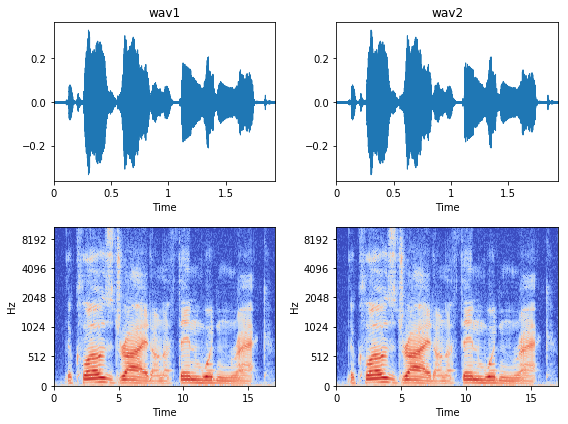

In [42]:
wav_tool.plot_wav_spec([wav,wav],['wav1','wav2'],fs,y_axis_type='mel',)

In [11]:
import matplotlib.pyplot as plt

In [18]:
aplt.figure

In [17]:
? plt.rc